In [1]:
#Loading libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
#Loading datasets
#Election results at state-level 1976-2016 (Source:https://electionlab.mit.edu/data)
elections = pd.read_csv('../input/us-elections-dataset/president-1976-2016.csv')

#2020 Presidental election at county-level result-incomplted(Source: https://www.kaggle.com/unanimad/us-election-2020 Version 61st)
this_year_data = pd.read_csv('../input/us-1976-2020-statelevel-presidential-elections/USA/2020president_county_candidate.csv')

#Voter turnout-rate(Source - Wikipedia)
turnout = pd.read_csv('../input/us-1976-2020-statelevel-presidential-elections/USA/turnout_rate.csv')
#US domographic indexes (Source: WorldBank Data)
dmg = pd.read_csv('../input/us-1976-2020-statelevel-presidential-elections/USA/USA_demographic.csv')

# electoral college votes by states 
electrol = pd.read_csv('../input/us-1976-2020-statelevel-presidential-elections/USA/electoral_vote.csv')

In [3]:
#Dropping unnecessary variables in elections dataset
elections.drop(['state_fips','state_cen', 'office', 'writein','version','notes','state_ic'],axis = 'columns',inplace = True)
elections.head()

,year,state,state_po,candidate,party,candidatevotes,totalvotes
0,1976,Alabama,AL,"Carter, Jimmy",democrat,659170,1182850
1,1976,Alabama,AL,"Ford, Gerald",republican,504070,1182850
2,1976,Alabama,AL,"Maddox, Lester",american independent party,9198,1182850
3,1976,Alabama,AL,"Bubar, Benjamin """"Ben""""",prohibition,6669,1182850
4,1976,Alabama,AL,"Hall, Gus",communist party use,1954,1182850


In [4]:
#Getting a dataframe which contains State and State_po
state_name = elections['state'].unique()
state_code = elections['state_po'].unique()
state_name = pd.DataFrame(state_name, columns=['state'])
state_code = pd.DataFrame(state_code, columns = ['state_po'])
state_namecode = pd.concat([state_name, state_code], axis = 1)

In [5]:
#This year election is in another dataset, get the total votes to state-level and add the 'Year' column
this_year = this_year_data.groupby(['state', 'candidate','party'])['votes'].sum()
this_year = this_year.to_frame()
this_year = this_year.reset_index()
this_year['year'] = 2020

In [6]:
#Add State_po to the dataframe of this year election
this_year_withcode = this_year.merge(state_namecode, on='state')
this_year_withcode.head()

,state,candidate,party,votes,year,state_po
0,Alabama,Write-ins,WRI,7274,2020,AL
1,Alabama,Donald Trump,REP,1434159,2020,AL
2,Alabama,Jo Jorgensen,LIB,24994,2020,AL
3,Alabama,Joe Biden,DEM,843473,2020,AL
4,Alaska,Brock Pierce,IND,297,2020,AK


In [7]:
#Calculate total votes for each candidate in each state
totalvotes_df = this_year.groupby('state')['votes'].sum()
totalvotes_df = totalvotes_df.reset_index()
totalvotes_df.rename(columns = {'votes':'totalvotes'},inplace = True)

#Add total state-level votes to this year dataframe
this_year_withcode = this_year_withcode.merge(totalvotes_df, on = 'state')
this_year_withcode.rename(columns = {'votes':'candidatevotes'}, inplace = True)

#Rename some other columns to be similar with elections dataset
this_year_withcode['party'].replace({'REP':'republican', 'DEM':'democrat'},inplace = True)
this_year_withcode.head()

,state,candidate,party,candidatevotes,year,state_po,totalvotes
0,Alabama,Write-ins,WRI,7274,2020,AL,2309900
1,Alabama,Donald Trump,republican,1434159,2020,AL,2309900
2,Alabama,Jo Jorgensen,LIB,24994,2020,AL,2309900
3,Alabama,Joe Biden,democrat,843473,2020,AL,2309900
4,Alaska,Brock Pierce,IND,297,2020,AK,131885


In [8]:
#Reorder the arrange of this year dataframe
this_year_withcode = this_year_withcode[['year','state', 'state_po', 'candidate','party', 'candidatevotes','totalvotes']]

#Merge the result of previous elections with the election this year
elections_full = pd.concat([elections,this_year_withcode])
elections_full = elections_full.reset_index()

elections_full.drop(['index'], axis =1, inplace = True)
elections_full.head()

,year,state,state_po,candidate,party,candidatevotes,totalvotes
0,1976,Alabama,AL,"Carter, Jimmy",democrat,659170,1182850
1,1976,Alabama,AL,"Ford, Gerald",republican,504070,1182850
2,1976,Alabama,AL,"Maddox, Lester",american independent party,9198,1182850
3,1976,Alabama,AL,"Bubar, Benjamin """"Ben""""",prohibition,6669,1182850
4,1976,Alabama,AL,"Hall, Gus",communist party use,1954,1182850


In [9]:
#Generate a column with the unique code for state, each year, for later joining purpose
elections_full['for_join'] =elections_full['year'].astype(str) + elections_full['state_po']

#Get the results for Republican and Democrats separately, then later join them side by side
democrat = elections_full.query("party=='democrat'")
republican = elections_full.query("party=='republican'")
df = republican.merge(democrat, on = 'for_join')

df.head()

,year_x,state_x,state_po_x,candidate_x,party_x,candidatevotes_x,totalvotes_x,for_join,year_y,state_y,state_po_y,candidate_y,party_y,candidatevotes_y,totalvotes_y
0,1976,Alabama,AL,"Ford, Gerald",republican,504070,1182850,1976AL,1976,Alabama,AL,"Carter, Jimmy",democrat,659170,1182850
1,1976,Alaska,AK,"Ford, Gerald",republican,71555,123574,1976AK,1976,Alaska,AK,"Carter, Jimmy",democrat,44058,123574
2,1976,Arizona,AZ,"Ford, Gerald",republican,418642,742719,1976AZ,1976,Arizona,AZ,"Carter, Jimmy",democrat,295602,742719
3,1976,Arkansas,AR,"Ford, Gerald",republican,267903,767535,1976AR,1976,Arkansas,AR,"Carter, Jimmy",democrat,498604,767535
4,1976,California,CA,"Ford, Gerald",republican,3882244,7803770,1976CA,1976,California,CA,"Carter, Jimmy",democrat,3742284,7803770


In [10]:
#Dropping duplicated columns and rename columns for using
df.drop(['year_y','state_y','state_po_y','party_x','party_y','totalvotes_x'], axis = 1, inplace = True)
df.rename(columns = {'year_x':'Year', 'state_x':'State','state_po_x':'state_po', 'candidate_x':'Rep_Candidate',
                    'candidatevotes_x':'Rep_votes','candidate_y':'Dem_Candidate', 'candidatevotes_y':"Dem_votes",
                     'totalvotes_y':'Total_votes'}, inplace = True)

In [11]:
#Adding electrol college votes to each states

electrol.rename(columns={'STATE':'state_po'}, inplace = True)
df = df.merge(electrol, on = 'state_po')
df.head()

,Year,State,state_po,Rep_Candidate,Rep_votes,for_join,Dem_Candidate,Dem_votes,Total_votes,ELECTORAL VOTE
0,1976,Alabama,AL,"Ford, Gerald",504070,1976AL,"Carter, Jimmy",659170,1182850,9
1,1980,Alabama,AL,"Reagan, Ronald",654192,1980AL,"Carter, Jimmy",636730,1341929,9
2,1984,Alabama,AL,"Reagan, Ronald",872849,1984AL,"Mondale, Walter",551899,1441713,9
3,1988,Alabama,AL,"Bush, George H.W.",815576,1988AL,"Dukakis, Michael",549506,1378476,9
4,1992,Alabama,AL,"Bush, George H.W.",804283,1992AL,"Clinton, Bill",690080,1688060,9


In [ ]:
df2 = pd.read_csv('../input/usa-election/president_county_candidate.csv')
map1 = pd.read_csv('../input/usa-election/US map.csv')
us = pd.read_csv('../input/president19762016winner/president-1976-2016.csv')

In [ ]:
def Electionmap(Name):
  Data = df2.iloc[(df2['candidate']==Name).values].groupby('state').sum()
  Datamap = pd.merge(Data,map1,left_on='state',right_on='usa_state')

  fig = px.choropleth(Datamap, locations='usa_state_code', color=Datamap.voted,
                           range_color=(0, 11e6),
                           locationmode = 'USA-states',  
                           scope="usa",
                           title='USA Presidential Votes Counts')
  fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
  fig.show()
Electionmap('Joe Biden')

In [12]:
#Checking if all candidate names are inified and no duplicated rows

print(df.groupby('Rep_Candidate')['Rep_Candidate'].count())
print(df.groupby('Dem_Candidate')['Dem_Candidate'].count())

Rep_Candidate
Bush, George H.W.    102
Bush, George W.      101
Dole, Robert          51
Donald Trump          51
Ford, Gerald          51
McCain, John          51
Mitt, Romney           1
Reagan, Ronald       102
Romney, Mitt          49
Trump, Donald J.      55
Name: Rep_Candidate, dtype: int64
Dem_Candidate
Carter, Jimmy       102
Clinton, Bill       102
Clinton, Hillary     54
Dukakis, Michael     51
Gore, Al             50
Joe Biden            51
Kerry, John          50
Mondale, Walter      51
Obama, Barack H.    101
Other                 1
Name: Dem_Candidate, dtype: int64


In [13]:
#Now,in df, there is only one row represent for one election in one state, 
# so the 'fo_join' value should be unique in order to ensure there are more than 1 row of result for an election in a state
#Filter for duplicated values 
for_filter = df.groupby('for_join')['for_join'].count() !=1
for_filter = for_filter.to_frame()
for_filter[for_filter['for_join']==True]

,for_join
for_join,
2004MD,True
2016AZ,True
2016MD,True


In [14]:
#Check the information of dupilcated values 
print(df[df['for_join']=='2004MD'])
print(df[df['for_join']=='2016AZ'])
print(df[df['for_join']=='2016MD'])

     Year     State state_po    Rep_Candidate  Rep_votes for_join  \
248  2004  Maryland       MD  Bush, George W.    1024703   2004MD   
249  2004  Maryland       MD  Bush, George W.    1024703   2004MD   

    Dem_Candidate  Dem_votes  Total_votes  ELECTORAL VOTE  
248   Kerry, John    1334493      2384238              10  
249         Other          7      2384238              10  
    Year    State state_po     Rep_Candidate  Rep_votes for_join  \
34  2016  Arizona       AZ  Trump, Donald J.    1252401   2016AZ   
35  2016  Arizona       AZ  Trump, Donald J.    1252401   2016AZ   

       Dem_Candidate  Dem_votes  Total_votes  ELECTORAL VOTE  
34  Clinton, Hillary    1161167      2573165              11  
35               NaN         42      2573165              11  
     Year     State state_po     Rep_Candidate  Rep_votes for_join  \
252  2016  Maryland       MD  Trump, Donald J.     943169   2016MD   
253  2016  Maryland       MD  Trump, Donald J.     943169   2016MD   
254  201

In [15]:
#Unify name for Mitt Romney, John Kerry and drop duplicated values 

df['Rep_Candidate'].replace({'Mitt, Romney':'Romney, Mitt'},inplace = True)
df['Dem_Candidate'].replace({'Other':'Kerry, John'},inplace = True)
df.drop([35,249, 253, 254,255],inplace = True)

In [16]:
#Creating new ratio columns for competing votes for each party

df['Rep_rate']=df['Rep_votes']/df['Total_votes']
df['Dem_rate']= df['Dem_votes']/df['Total_votes']
df['Rep_Win?']= df['Rep_rate'] - df['Dem_rate']



In [17]:
#Separate the data to 2 parts due to the difference in electoral college votes policies

partial = pd.concat([df[df['state_po']=='ME'], df[df['state_po']=='NE']])
whole = df[df['state_po']!='ME']
whole = whole[whole['state_po']!='NE']

In [18]:
#Calculate electrol college votes for candidates in ME AND NE
partial['Dem_electrolvote'] = round(df['Dem_rate']*df['ELECTORAL VOTE'],0)
partial['Rep_electrolvote'] = round(df['Rep_rate']*df['ELECTORAL VOTE'],0)

In [19]:
#Calculate electrol college votes for candidates in "Winner takes it all" - states
whole['Dem_electrolvote'] = np.where(whole['Rep_Win?']>0, 0, whole['ELECTORAL VOTE'])
whole['Rep_electrolvote'] = np.where(whole['Rep_Win?']<0, 0, whole['ELECTORAL VOTE'])
 

In [20]:
#Join the two type of electrol votes policy states
full_result = pd.concat([partial, whole])

#Get the table to make the heat map
wise_party = full_result[['Year', 'State', 'Rep_Win?']]

#Convert to pivot table
wise_party = wise_party.pivot(index = 'State', columns = 'Year', values = 'Rep_Win?')

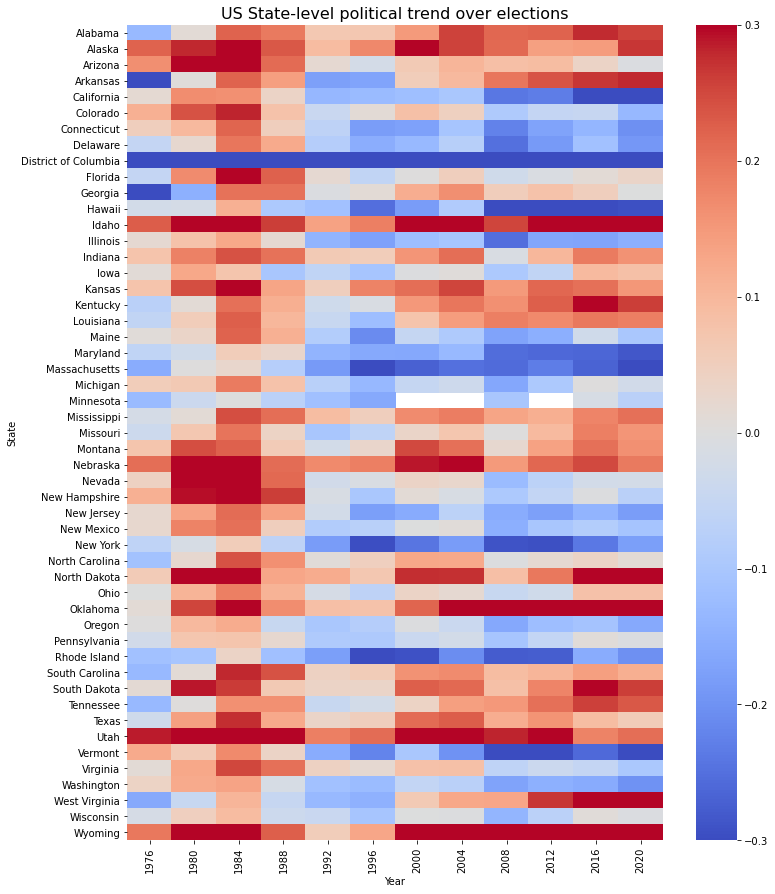

In [21]:
#Plotting the political trend in states 
g = sns.heatmap(wise_party, vmax = 0.3, vmin = -0.3, cmap = 'coolwarm', center = 0, yticklabels = True)
g.set_title('US State-level political trend over elections', size = 16, y = 1.05)
g.figure.set_size_inches(12, 15)
fig = g.get_figure()
fig.savefig('State-levelheatmap.jpg')

In [22]:
#Calculate for the president-elected 
national_level = full_result.groupby(['Year','Rep_Candidate','Dem_Candidate'])['Rep_votes',
                                                                                    'Dem_votes','Dem_electrolvote',
                                                                                    'Rep_electrolvote','Total_votes'].sum()
national_level=national_level.reset_index()

#Creating new columns for comparing ratios

national_level['Rep_rate']=national_level['Rep_votes']/national_level['Total_votes']
national_level['Dem_rate']= national_level['Dem_votes']/national_level['Total_votes']
national_level['Rep_Win?']= (national_level['Rep_rate'] - national_level['Dem_rate'])*1000
national_level['Rep_Win?votecount'] = national_level['Rep_votes'] - national_level['Dem_votes']

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  


In [23]:
#President-elected is the one who gets over the threshold 270 electrol college votes

national_level['President-Elected']=np.where(national_level['Rep_electrolvote']>270, 
                                                  national_level['Rep_Candidate'], national_level['Dem_Candidate'])

In [24]:
#The result may have minor vary from the official result due to the authenticity of the data and the policy changing at
#certain states/counties 
national_level['Presidentforshort'] = ['Carter', 'Reagan', 'Reagan ', 'Bush.', 'Clinton', 
                                            'Clinton ', 'Bush', 'Bush ', 'Obama', 'Obama ', 'Trump', 'Biden']
national_level.to_csv('National_level_president_election.csv')

In [25]:
national_level

,Year,Rep_Candidate,Dem_Candidate,Rep_votes,Dem_votes,Dem_electrolvote,Rep_electrolvote,Total_votes,Rep_rate,Dem_rate,Rep_Win?,Rep_Win?votecount,President-Elected,Presidentforshort
0,1976,"Ford, Gerald","Carter, Jimmy",38870893,40680446,293.0,238.0,81601344,0.476351,0.498527,-22.175529,-1809553,"Carter, Jimmy",Carter
1,1980,"Reagan, Ronald","Carter, Jimmy",43642639,35480948,83.0,447.0,86496851,0.504558,0.410199,94.358244,8161691,"Reagan, Ronald",Reagan
2,1984,"Reagan, Ronald","Mondale, Walter",54166829,37449813,16.0,515.0,92654861,0.584609,0.404186,180.422439,16717016,"Reagan, Ronald",Reagan
3,1988,"Bush, George H.W.","Dukakis, Michael",48642640,41716679,100.0,431.0,91586825,0.531110,0.455488,75.621805,6925961,"Bush, George H.W.",Bush.
4,1992,"Bush, George H.W.","Clinton, Bill",38798913,44856747,351.0,177.0,104599780,0.370927,0.428842,-57.914405,-6057834,"Clinton, Bill",Clinton
5,1996,"Dole, Robert","Clinton, Bill",39003697,47295351,364.0,166.0,96389818,0.404645,0.490667,-86.022094,-8291654,"Clinton, Bill",Clinton
6,2000,"Bush, George W.","Gore, Al",49201713,49662314,238.0,283.0,103155297,0.476967,0.481433,-4.465122,-460601,"Bush, George W.",Bush
7,2004,"Bush, George W.","Kerry, John",60526016,57449540,231.0,290.0,119521063,0.506405,0.480665,25.740032,3076476,"Bush, George W.",Bush
8,2008,"McCain, John","Obama, Barack H.",59613835,69338846,353.0,178.0,131419253,0.453616,0.527616,-73.999896,-9725011,"Obama, Barack H.",Obama
9,2012,"Romney, Mitt","Obama, Barack H.",59349892,64205850,317.0,204.0,126203436,0.470272,0.508749,-38.477225,-4855958,"Obama, Barack H.",Obama


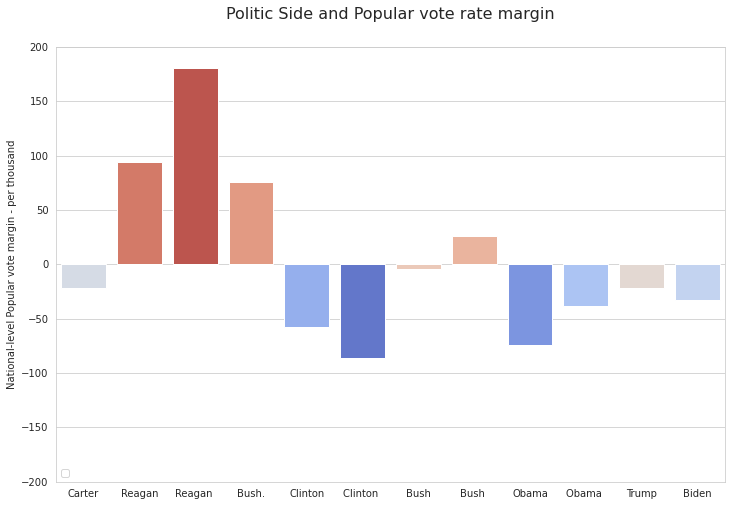

In [26]:
sns.set_style('whitegrid')
g = sns.barplot(x = 'Presidentforshort', y = 'Rep_Win?', data = national_level, hue = 'Rep_Win?', palette='coolwarm', dodge = False)
g.legend([])
g.figure.set_size_inches(12, 8)
g.set_title('Politic Side and Popular vote rate margin', size = 16, y = 1.05)
g.set(ylabel = 'National-level Popular vote margin - per thousand', 
     ylim=(-200, 200))
g.set_xlabel('')
fig = g.get_figure()
fig.savefig('Politicside.jpg')

In [27]:
#Plotting the differences 
my_range=range(1,len(national_level.index)+1)

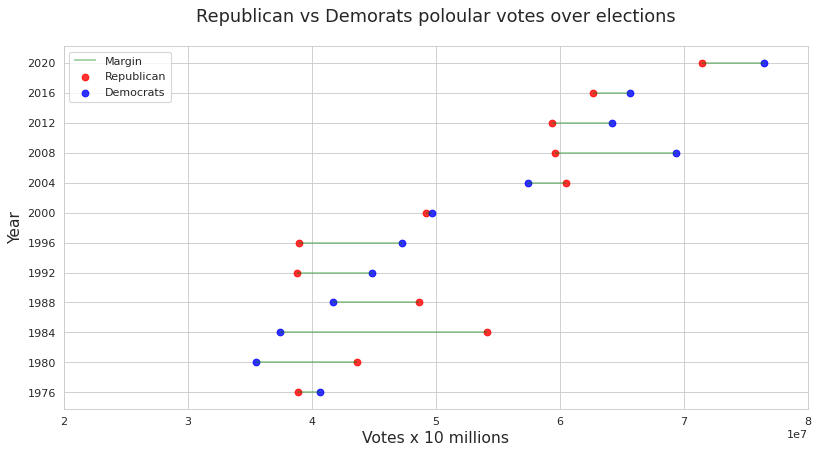

In [28]:
#Plotting the margin of popular votes
import seaborn as sns
from matplotlib.pyplot import figure
figure(num=None, figsize=(12, 6), dpi=80, facecolor='w', edgecolor='k')
sns.set_style('whitegrid')

plt.hlines(y = my_range, xmin = national_level['Rep_votes'], 
           xmax =national_level['Dem_votes'], color = 'green', alpha = 0.4)
plt.scatter(national_level['Rep_votes'], my_range, color = 'red', alpha = 0.8)
plt.scatter(national_level['Dem_votes'], my_range, color = 'blue', alpha = 0.8)
plt.legend(['Margin','Republican','Democrats'])
plt.yticks(np.arange(1, 13, step=1), 
           labels = (national_level['Year']))
plt.ylabel('Year', size = 14)
plt.xlim(20000000,80000000)
plt.xlabel('Votes x 10 millions', size = 14)
plt.title('Republican vs Demorats poloular votes over elections', size = 16, y = 1.05)
plt.savefig('Popularvote_margin.jpg')

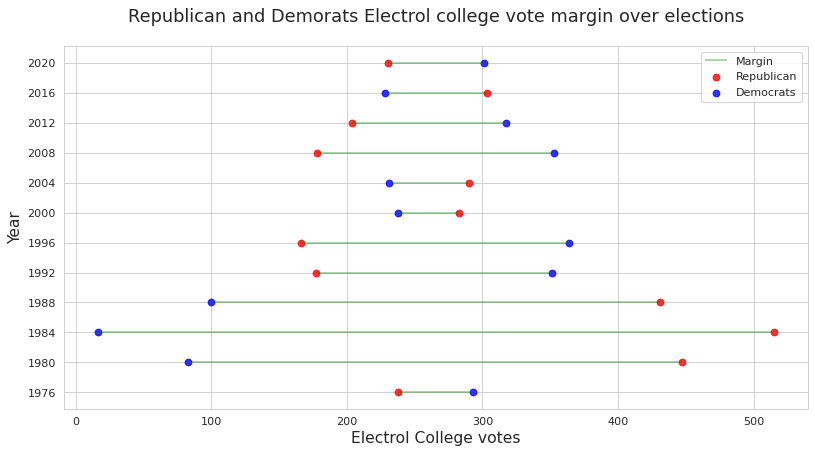

In [29]:
#Plotting the margins of electrol college votes
figure(num=None, figsize=(12, 6), dpi=80, facecolor='w', edgecolor='k')
plt.hlines(y = my_range, xmin = national_level['Rep_electrolvote'], 
           xmax =national_level['Dem_electrolvote'], color = 'green', alpha = 0.4)
plt.scatter(national_level['Rep_electrolvote'], my_range, color = 'red', alpha = 0.8)
plt.scatter(national_level['Dem_electrolvote'], my_range, color = 'blue', alpha = 0.8)
plt.legend(['Margin','Republican','Democrats'])
plt.yticks(np.arange(1, 13, step=1), 
           labels = (national_level['Year']))
plt.ylabel('Year', size = 14)
plt.xlabel('Electrol College votes', size = 14)
plt.title('Republican and Demorats Electrol college vote margin over elections', size = 16, y = 1.05)
plt.savefig('Electrol-collegevote-margin.jpg')

In [30]:
#Get the turn-out ratios
turnout['VEP/Pop_rate'] = turnout['VEP']/turnout['Population']
turnout['Turnout/Pop_rate'] = turnout['Turnout']/turnout['Population']
turnout['Turnout/VEP_rate'] = turnout['Turnout']/turnout['VEP']

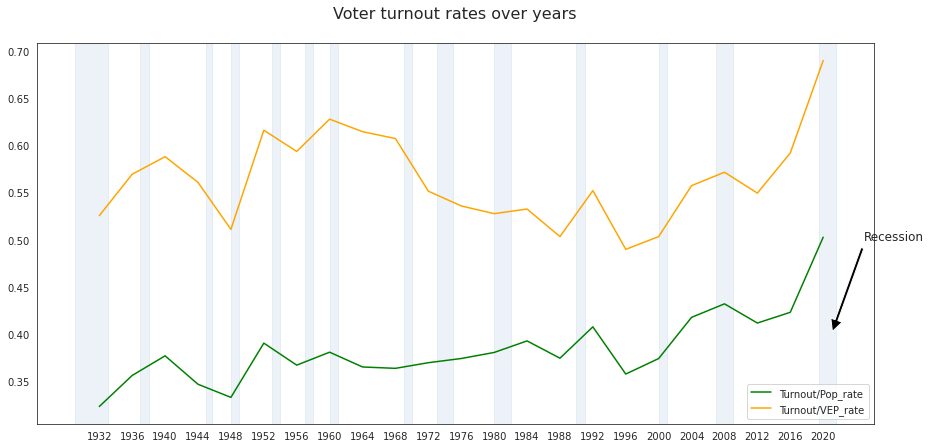

In [31]:
#Plotting Voter turnout overtime
sns.set_style('white')
fig, ax = plt.subplots(figsize=(15, 7))
ax.axvspan(1929,1933,color='steelblue',alpha=0.1)
ax.axvspan(1937,1938,color='steelblue',alpha=0.1)
ax.axvspan(1945,1945.7,color='steelblue',alpha=0.1)
ax.axvspan(1948,1949,color='steelblue',alpha=0.1)
ax.axvspan(1953,1954,color='steelblue',alpha=0.1)
ax.axvspan(1957,1958,color='steelblue',alpha=0.1)
ax.axvspan(1960,1961,color='steelblue',alpha=0.1)
ax.axvspan(1969,1970,color='steelblue',alpha=0.1)
ax.axvspan(1973,1975,color='steelblue',alpha=0.1)
ax.axvspan(1980,1982,color='steelblue',alpha=0.1)
ax.axvspan(1990,1991,color='steelblue',alpha=0.1)
ax.axvspan(2000,2001,color='steelblue',alpha=0.1)
ax.axvspan(2007,2009,color='steelblue',alpha=0.1)
ax.axvspan(2019.5,2021.5,color='steelblue',alpha=0.1)
ax.plot(turnout['Year'], turnout['Turnout/Pop_rate'], color = 'green')
ax.plot(turnout['Year'], turnout['Turnout/VEP_rate'], color = 'orange')
ax.legend(['Turnout/Pop_rate','Turnout/VEP_rate'])
ax.set_title('Voter turnout rates over years', size = 16, y = 1.05)
ax.set_xticks(turnout['Year'])
plt.annotate('Recession', xy = (2021, 0.4), xytext =(2025, 0.5),
            arrowprops = {'facecolor':'black', 'width':3, 'shrink':0.03}, size = 12)
plt.savefig('Turnout-rate&Recession.jpg')

In [32]:
dmg=dmg[dmg['Year']>1970]

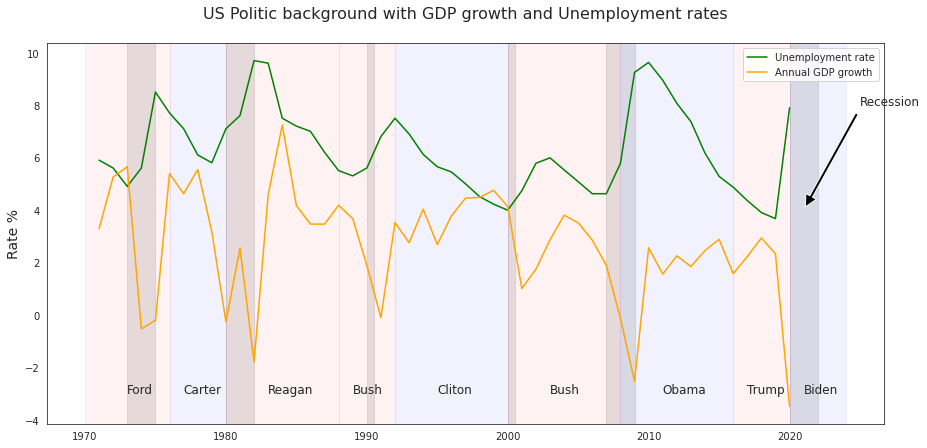

In [33]:
#Plotting USA economy and society over times
fig, bx = plt.subplots(figsize=(15, 7))
bx.axvspan(1973,1975,color='grey',alpha=0.2)
bx.axvspan(1980,1982,color='grey',alpha=0.2)
bx.axvspan(1990,1990.5,color='grey',alpha=0.2)
bx.axvspan(2000,2000.5,color='grey',alpha=0.2)
bx.axvspan(2007,2009,color='grey',alpha=0.2)
bx.axvspan(2020,2022,color='grey',alpha=0.2)
bx.axvspan(1970,1976,color='red',alpha=0.05)
bx.axvspan(1976,1980,color='blue',alpha=0.05)
bx.axvspan(1980,1988,color='red',alpha=0.05)
bx.axvspan(1988,1992,color='red',alpha=0.05)
bx.axvspan(1992,2000,color='blue',alpha=0.05)
bx.axvspan(2000,2008,color='red',alpha=0.05)
bx.axvspan(2008,2016,color='blue',alpha=0.05)
bx.axvspan(2016,2020,color='red',alpha=0.05)
bx.axvspan(2020,2024,color='blue',alpha=0.05)
bx.plot(dmg['Year'], dmg['Unemployment_rate'], color = 'green')
bx.plot(dmg['Year'], dmg['Annual_GDP_growth'], color = 'orange')
bx.legend(['Unemployment rate', 'Annual GDP growth'])
bx.set_title('US Politic background with GDP growth and Unemployment rates', size = 16, y = 1.05)
bx.set_ylabel('Rate %', size = 14)
plt.text(1973, -3, 'Ford', size = 12)
plt.text(1977, -3, 'Carter', size = 12)
plt.text(1983, -3, 'Reagan', size = 12)
plt.text(1989, -3, 'Bush', size = 12)
plt.text(1995, -3, 'Cliton', size = 12)
plt.text(2003, -3, 'Bush', size = 12)
plt.text(2011, -3, 'Obama', size = 12)
plt.text(2017, -3, 'Trump', size = 12)
plt.text(2021, -3, 'Biden', size = 12)
plt.annotate('Recession', xy = (2021, 4), xytext =(2025, 8),
            arrowprops = {'facecolor':'black', 'width':3, 'shrink':0.03}, size = 12)
plt.savefig('Politic_and_economy.jpg')